In [1]:
from src import util as util
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import collections
from pathlib import Path
import csv

In [2]:
def load_spam_dataset_csv(csv_path):

    messages = []
    labels = []

    with open(csv_path, 'r', newline='', encoding='utf8') as csv_file:
        reader = csv.reader(csv_file, delimiter=',')

        for message, label in reader:
            messages.append(message)
            labels.append(1 if label == '1' else 0)

    return messages, np.array(labels)

In [3]:
train_messages, train_labels = util.load_spam_dataset('data/train.tsv')
test_messages, test_labels = util.load_spam_dataset('data/test.tsv')
train2_messages, train2_labels = load_spam_dataset_csv('data/emails_new_train.csv')
val_messages, val_labels = util.load_spam_dataset('data/val.tsv')

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
from typing import Optional, Union
from pathlib import Path

def detect_encoding(file_path: str) -> str:
    """Detect file encoding using chardet"""
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
    return result['encoding']

def show_message_distributions(
    file_path: Union[str, Path],
    text_col: str = 'text',
    label_col: str = 'spam',
    label_mapping: Optional[dict] = None,
    positive_class: str = 'Spam',
    negative_class: str = 'Ham'
) -> None:
    """
    Display professional visualizations for message classification distributions.
    
    Args:
        file_path: Path to CSV/TSV file containing message data
        text_col: Name of column containing message text
        label_col: Name of column containing labels
        label_mapping: Optional dictionary to map raw labels to display names
        positive_class: Name to use for positive class in visualizations
        negative_class: Name to use for negative class in visualizations
    """
    # Determine file type and set separator
    file_path = Path(file_path)
    if file_path.suffix.lower() == '.tsv':
        sep = '\t'
    else:  # default to CSV
        sep = ','
    
    # Load data with encoding detection
    try:
        try:
            data = pd.read_csv(file_path, sep=sep)
        except UnicodeDecodeError:
            encoding = detect_encoding(file_path)
            data = pd.read_csv(file_path, sep=sep, encoding=encoding)
    except Exception as e:
        print(f"Failed to read file: {e}")
        print(f"Supported formats: CSV (.csv) or TSV (.tsv)")
        return

    # Validate columns
    if label_col not in data.columns:
        print(f"Error: Column '{label_col}' not found in data")
        print(f"Available columns: {list(data.columns)}")
        return
    if text_col not in data.columns:
        print(f"Error: Column '{text_col}' not found in data")
        print(f"Available columns: {list(data.columns)}")
        return

    # Standardize labels
    unique_labels = data[label_col].unique()
    
    # Auto-detect label mapping if not provided
    if label_mapping is None:
        if set(map(str, unique_labels)) <= {'0', '1'}:
            label_mapping = {'0': negative_class, '1': positive_class}
        elif set(map(str.lower, map(str, unique_labels))) <= {'ham', 'spam', 'negative', 'positive'}:
            label_mapping = {
                'ham': negative_class, 'spam': positive_class,
                'negative': negative_class, 'positive': positive_class
            }
    
    if label_mapping:
        # Map labels to standardized names
        data['_plot_label'] = data[label_col].astype(str).map(label_mapping)
        data['_numeric_label'] = data[label_col].astype(str).map(
            {k: i for i, k in enumerate(label_mapping)}
        )
    else:
        # Use raw labels if no mapping provided
        data['_plot_label'] = data[label_col].astype(str)
        data['_numeric_label'] = pd.factorize(data[label_col])[0]
    
    # Filter valid data
    valid_data = data.dropna(subset=['_plot_label', '_numeric_label'])
    if len(valid_data) == 0:
        print("Error: No valid labels found after conversion")
        return

    # Set professional style
    sns.set_theme(style="whitegrid")
    plt.style.use('seaborn-v0_8')
    
    # Create figure
    plt.figure(figsize=(14, 6))
    
    # 1. Bar plot - Distribution
    plt.subplot(1, 2, 1)
    ax = sns.countplot(
        x='_numeric_label', 
        hue='_numeric_label',
        data=valid_data, 
        palette="viridis", 
        legend=False
    )
    
    # Get sorted labels
    label_order = valid_data[['_numeric_label', '_plot_label']]\
        .drop_duplicates()\
        .sort_values('_numeric_label')
    xtick_labels = [f"{row['_plot_label']} ({row['_numeric_label']})" 
                   for _, row in label_order.iterrows()]
    
    ax.set_xticks(range(len(label_order)))
    ax.set_xticklabels(xtick_labels)
    plt.title('Message Classification Distribution', fontsize=12, fontweight='bold')
    plt.xlabel('Message Type')
    plt.ylabel('Count')
    
    # Add value labels
    for p in ax.patches:
        ax.annotate(
            f'{p.get_height():,}', 
            (p.get_x() + p.get_width()/2, p.get_height()), 
            ha='center', va='center', 
            xytext=(0, 7), 
            textcoords='offset points',
            fontsize=10,
            fontweight='bold'
        )

    # 2. Pie chart - Proportion
    plt.subplot(1, 2, 2)
    counts = valid_data['_plot_label'].value_counts()
    
    # Use standard colors for binary case, otherwise viridis
    if len(counts) == 2:
        colors = ['#66b3ff', '#ff9999']  # Blue for negative, Red for positive
    else:
        colors = sns.color_palette("viridis", len(counts))
    
    plt.pie(
        counts,
        labels=counts.index,
        autopct=lambda p: f'{p:.1f}%\n({int(p/100*sum(counts)):,})',
        colors=colors,
        startangle=90,
        explode=[0.05]*len(counts),
        shadow=True,
        textprops={'fontsize': 10, 'fontweight': 'bold'},
        wedgeprops={'linewidth': 1.5, 'edgecolor': 'white'}
    )
    
    plt.title('Message Classification Proportion', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()


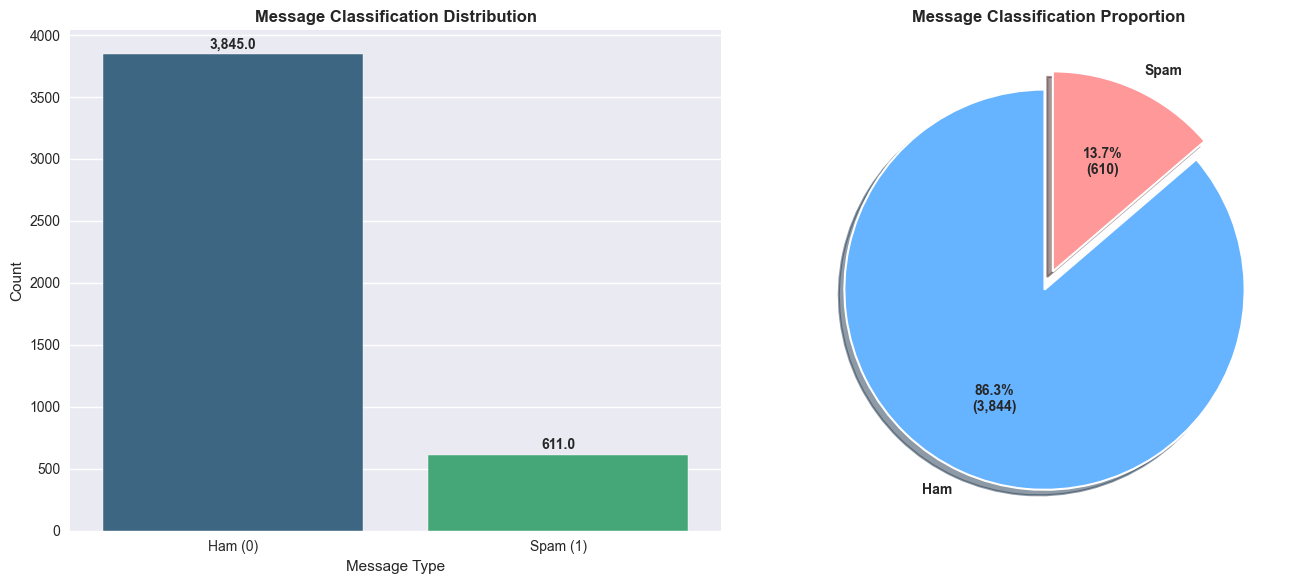

In [5]:
show_message_distributions("data/train.tsv",'THANX 4 PUTTIN DA FONE DOWN ON ME!!','ham')

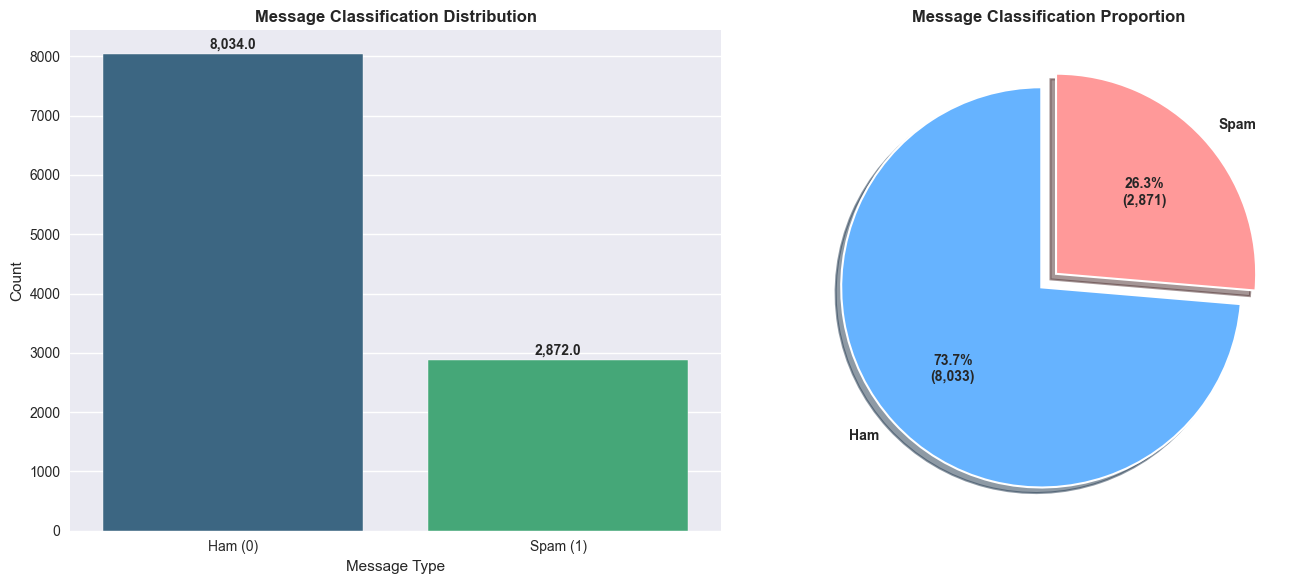

In [6]:
show_message_distributions("data/emails_new_train.csv")

In [7]:
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
# More robust tokenization with error handling
def safe_tokenize(text):
    try:
        return word_tokenize(str(text).lower())
    except:
        return str(text).lower().split()  # Fallback to simple whitespace splitting

tokenized_messages = [safe_tokenize(msg) for msg in train_messages]

In [9]:
# Train Word2Vec model with optimized parameters
print("Training Word2Vec model...")
w2v_model = Word2Vec(
    sentences=tokenized_messages,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    epochs=20,
    sg=1,  # Use skip-gram (better for small datasets)
    hs=0,  # Use negative sampling
    negative=5  # Number of negative samples
)

Training Word2Vec model...


In [10]:
def message_to_vector(message, model, vector_size=100):
    words = safe_tokenize(message)
    word_vectors = []
    for word in words:
        try:
            if word in model.wv:
                word_vectors.append(model.wv[word])
        except AttributeError:
            # Handle case where model isn't properly trained
            pass
    
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    return np.zeros(vector_size)

In [11]:
len(train_messages)

4457

In [12]:
Xhh_train = np.array([message_to_vector(msg, w2v_model) for msg in train_messages])

already prtrained

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from sklearn.decomposition import PCA
import gensim.downloader as api
from gensim.models import KeyedVectors

In [14]:
# Load pre-trained embeddings (choose one)
embeddings = api.load("glove-twitter-100")  # Best for SMS-style text
# embeddings = api.load("word2vec-google-news-300")  # Larger vocabulary

In [15]:
def message_to_vector(messages, embedding_model):
    vectors = []
    for msg in messages:
        words = msg.lower().split()  # Simple tokenizer
        word_vecs = [embedding_model[word] for word in words if word in embedding_model]
        vectors.append(np.mean(word_vecs, axis=0) if word_vecs else np.zeros(100))
    return np.array(vectors)

In [16]:
Train_matrix3 = message_to_vector(train_messages, embeddings)
Test_matrix3 = message_to_vector(test_messages, embeddings)

In [17]:
def getwords(message):
    return message.lower().split()

In [18]:
def h(theta,x):
    return 1 / (1 + np.exp(-np.dot(x, theta)))

In [19]:
def Create_dictionary(messages):
    words = [word for message in messages for word in getwords(message)]
    words_count = collections.Counter(words)
    #word_dic = {(word, count) for word,count in words_count.items() if count>=5}
    freq_word = [word for word,count in words_count.items() if count>=10 and word !='subject:']
    return {word: count for count, word in enumerate(freq_word)}

In [20]:
dicWords = Create_dictionary(train_messages)

In [21]:
def Transform_text(messages, word_dictionary):
    m = len(messages)
    n = len(word_dictionary)
    matrix = np.zeros((m,n), dtype=int)

    word_counts = [collections.Counter(getwords(message)) for message in messages]
    for i in range(m):
        for word, count in word_counts[i].items():
            if word in word_dictionary:
                matrix[i][word_dictionary[word]] += count

    return matrix


In [22]:
train_matrix = Transform_text(train_messages,dicWords)

In [23]:
train_matrix.shape

(4457, 877)

In [24]:
Train_matrix3.shape

(4457, 100)

In [25]:
X_with_bias = np.c_[np.ones(Train_matrix3.shape[0]),Train_matrix3]

In [26]:
class LogisticRegressionWithGD:
    def __init__(self,alpha=0.1,iteration=1000):
        self.alpha = alpha
        self.iteration=iteration
        self.theta=None
    def h(self,theta, x):
        return 1 / (1 + np.exp(-np.dot(x, theta)))
    def fit(self,x,y):
        lambda_ = 1
        n,m = x.shape
        X_with_bias = np.c_[np.ones(n),x]
        self.theta = np.zeros(m+1)
        #Gradient
        for i in range(self.iteration):
            #With regularization
            linearmodel = (np.dot(X_with_bias.T, (self.h(self.theta, X_with_bias)-y))/m)
            L1_reg = np.sign(self.theta)*lambda_

            L2_reg = lambda_*self.theta
            linearmodel += L2_reg
            self.theta = self.theta - self.alpha*linearmodel
        
        
    def predict(self,x):
        X_with_bias = np.c_[np.ones(x.shape[0]),x]
        y_predicted = 1/(1+np.exp(-X_with_bias.dot(self.theta)))
        y_result = [1 if i>0.5 else 0 for i in y_predicted]
        return y_result

In [27]:
LR = LogisticRegressionWithGD(alpha=0.01,iteration=1000)
LR.fit(Train_matrix3,train_labels)
LR_predictions = LR.predict(Test_matrix3)

In [28]:
LR_accuracy = np.mean(LR_predictions == test_labels)

In [29]:
print('SimpLe Logistic Regression had an accuracy of {} on the testing set'.format(LR_accuracy))

SimpLe Logistic Regression had an accuracy of 0.9086021505376344 on the testing set


In [30]:
simpletesting=[
'buy on site this product now',
    'Get new phone free Click this URL',
"Don't forget to Subscribe our page in www.hh.com",
"Urgent your Account has been compromised. Verify your details now",
    "Making $5000 a week working from home. No Skills required",
"Your Package delivery failed. Click here to reschedule",
    "Act now this offer expires in 24 hours",
    "Get rich quick with this one simple trick",
    "Warning: your computer is as risk. Download this antivirus now "
]

use Large dataset

In [31]:
Train_matrix32 = message_to_vector(train2_messages, embeddings)

In [32]:
LR2 = LogisticRegressionWithGD(alpha=0.01,iteration=1000)
LR2.fit(Train_matrix32,train2_labels)

In [33]:
LR_predictions2 = LR2.predict(Test_matrix3)
LR_accuracy2 = np.mean(LR_predictions2 == test_labels)

In [34]:
print('SimpLe Logistic Regression with large dataset had an accuracy of {} on the testing set'.format(LR_accuracy2))

SimpLe Logistic Regression with large dataset had an accuracy of 0.8727598566308243 on the testing set
